# How To Search for QPOs with BayesPSD

This notebook is a demonstration for how to use the code in this package
to search for quasi-periodic oscillations (QPOs) in X-ray data of bursts.

This code requires
* python 2.7 or later (not really tested with python 3)
* numpy
* scipy
* matplotlib

Recommended
* emcee (https://github.com/dfm/emcee)
* acor (https://github.com/dfm/acor)
* statsmodels (https://github.com/statsmodels/statsmodels; only for using crazy minimization algorithms that don't return the inverse covariance)
* seaborn for making pretty plots (http://stanford.edu/~mwaskom/software/seaborn/)

## Basics

The module contains both the code to do Bayesian inference on bursty time series, as well 
as some basic class definitions that are useful for time series analysis in general, and for
*Fermi*/GBM data in particular.

Let's start with a simple time series in a data file. This is actually a magnetar bursts from 
a source called SGR J1550-5418, but that's not important right now. 
I've made things easy for you here: the data are individual photon events and energies only from 
the part of the observation where the burst was observed. We'll have a look at more complicated 
data and how to automate the steps outlined below later.

For now, let's import some code and load the time series.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## this is just to make plots prettier
## comment out if you don't have seaborn
import seaborn as sns 
sns.set()
########################################

import numpy as np


**NOTE**: You need to have the directory where you saved the BayesPSD code in your `PYTHONPATH` variable for the following to work! If you haven't set your variable externally, you can do it in the following way:


In [3]:
import sys
sys.path.append("/Users/danielahuppenkothen/work/repositories/")

Be aware that you need to replace the directory structure with your own, and that you need to add the path to the directory in which the BayesPSD folder is located. In my case, that's in my `repositories` folder in my work directory on my home folder, but it will be different for you!
Also, when importing below, `bayespsd` needs to be written exactly as the name of the folder (it's case sensitive!). 

Now we can import functions and classes from that package:

In [6]:
from BayesPSD import Lightcurve, PowerSpectrum

The data are saved in a simple text file:

In [9]:
## the directory where we've stored the data
datadir = "../data/" 

data = np.loadtxt(datadir+"090122283_+071.87300_eventfile.dat")
print("Data shape : " + str(data.shape))

Data shape : (13001, 2)


The result is a numpy-array with 130001 rows and 2 columns. Each row is a photon, the first column contains the photon arrival times, the second column the energies.

For now, let's not care about the energies (don't worry, we'll get back to that later!).
Let's make a light curve and plot it:

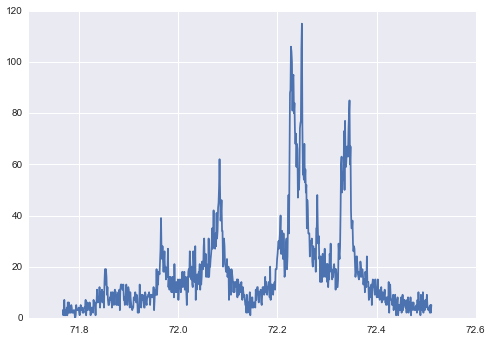

In [14]:
timestep = 0.001 ##the time resolution for the light curve
lc = Lightcurve(data[:,0], timestep=timestep)

plt.figure()
plt.plot(lc.time, lc.counts)

There you go, it's a burst. The class `Lightcurve` has several useful attributes. Have a look at the code if you're interested. It works both with time tagges arrival times (in which case it takes a value `timestep` for the output time resolution) or with counts, in which case you should use the keyword `times` for time bins and `counts` for the counts per bin.

The next step is to make a periodogram. This is easy if we already have a `Lightcurve` object.
Note that we'll use `loglog` for the figure rather than `plot`, because the spectrum is better plotted on a log-log scale.

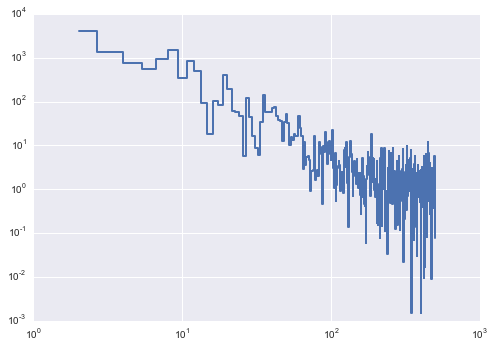

In [17]:
ps = PowerSpectrum(lc, norm="leahy")

plt.loglog(ps.freq[1:], ps.ps[1:], lw=2, linestyle="steps-mid")

The `PowerSpectrum` class comes with three normalizations built-in: `leahy` for the Leahy normalization, `rms` for a rms-normalized periodogram and `variance` for a periodogram that is normalized to the total variance.

For most purposes here, the Leahy normalization (default) is probably what you want, but the other options are there if you want them.

So far, we haven't actually done any analysis. Let's first talk about models.
All parametric models are saved in the model `parametricmodels.py`.

In [22]:
from BayesPSD import pl, bpl, const, qpo

We can now, for example, fit one of these models to the data.
This kind of fitting is implemented in the class `PerMaxLike`, which, despite its name
actually usually does maximum-a-posteriori estimates rather than maximum likelihood estimates.


In [24]:
from BayesPSD import PerMaxLike

psfit = PerMaxLike(ps, obs=True, fitmethod="bfgs")

`PerMaxLike` takes a `PowerSpectrum` object. The variable `obs` controls whether output plots and logs are produced (set True if you want those!) and `fitmethod` sets one of the optimization algorithms specified in scipy.optimize.
My recommendation is to set to `bfgs` unless you have a good reason not to.

In order to actually fit a model to the periodogram, we'll need to specify what model, and will also have to set starting guesses for the parameters. Note that the number of parameters. Look at the function definitions for details about the different models. In the case below, we'll use a simple power law model, which takes the power law index, the log(amplitude) and log(background).

The actual fitting is implemented in method `mlest`. For details on all parameters this method takes, see the documentation. Below are the most important ones. Again, we can set whether the code should produce plots and be verbose, and we can set whether the periodogram we use is the simple Fourier transform of a light curve (m=1) or whether it is the average of several periodograms (or frequency bins). 
If `map` is True, the code will produce the maximum-a-posteriori estimate, otherwise it'll return a Maximum Likelihood estimate.

In [31]:
## starting parameters
pars = [2,10,np.log(2.0)]

fitparams = psfit.mlest(pl, pars, obs=True, m=1, map=True)

Gradient and/or function calls not changing!
Approximating covariance from BFGS: 
Covariance (empirical): [[ 0.02036338  0.0781775   0.0117943 ]
 [ 0.0781775   0.31121761  0.041365  ]
 [ 0.0117943   0.041365    0.01405316]]
The best-fit model parameters plus errors are:
Parameter 0: 2.08723748958 +/- 0.142700328632
Parameter 1: 11.1100661977 +/- 0.557868814871
Parameter 2: 0.457427143928 +/- 0.118546023877
The Akaike Information Criterion of the power law model is: 887.00711241.
The figure-of-merit function for this model is: 359.736396168 and the fit for 368.0 dof is 0.977544554804.
Fitting statistics: 
 -- number of frequencies: 371
 -- Deviance [-2 log L] D = 1762.01422482
 -- Highest data/model outlier 2I/S = 13.5363506735
    at frequency f_max = 450.940860213
 -- Highest smoothed data/model outlier for smoothing factor [3] 2I/S = 7.5281022425
    at frequency f_max = 452.284946234
 -- Highest smoothed data/model outlier for smoothing factor [5] 2I/S = 5.91861983855
    at frequen

The fitting routine returns a dictionary with lots of interesting and useful information. Let's have a look at the dictionary keys:

In [32]:
print(fitparams.keys())

['maxind', 'smooth3', 'smooth5', 'merit', 'result', 'popt', 's11maxfreq', 'maxpow', 's5maxfreq', 's5max', 's3max', 's11max', 's3maxfreq', 'bindict', 'maxfreq', 'bic', 'sexp', 'smooth11', 'ssd', 'ksp', 'err', 'deviance', 'cov', 'dof', 'mfit', 'sobs', 'model', 'aic']


Here are the most interesting ones:

In [34]:
print("The best-fit parameters are " + str(fitparams["popt"]))
print("The covariance matrix for the parameters is: " + str(fitparams["cov"]))
print("The MAP estimate (or Maximum Likelihood estimate) is %.3f"%fitparams["result"])
print("The deviance (-2*log(maximum likelihood)) is %.3f"%fitparams["deviance"])
print("The Akaike Information Criterion is %.3f."%fitparams["aic"])
print("The Bayesian Information Criterion is %.3f."%fitparams["bic"])

The best-fit parameters are [  2.08723749  11.1100662    0.45742714]
The covariance matrix for the parameters is: [[ 0.02036338  0.0781775   0.0117943 ]
 [ 0.0781775   0.31121761  0.041365  ]
 [ 0.0117943   0.041365    0.01405316]]
The MAP estimate (or Maximum Likelihood estimate) is 881.007
The deviance (-2*log(maximum likelihood)) is 1762.014
The Akaike Information Criterion is 887.007.
The Bayesian Information Criterion is 1994.007.


A side note: likelihoods, priors and posteriors are implemented in `Posterior` and its subclasses. 
Currently (fairly uninformative) priors are hard-coded. If you need different priors, my suggestion is to fork the repository and implement them in a separate branch. 

So now comes the fun bit: we can do the actual QPO search! Most of that is implemented in the class `Bayes`. Its constructor takes a `PowerSpectrum` object and various parameters: 

In [ ]:
from BayesPSD import Bayes

bb = Bayes(ps, namestr='demo', plot=True, m=1)

The variable `namestr` allows you do set a string identifier for all output plots and text files. This is especially useful if you run many bursts and need to save each in its own separate file.

The variable `plot` controls whether the code produces output plots for diagnostic purposes. This is usually a useful feature to leave on. 

Finally, the periodogram we just produced above is a simple Fourier transform of a single light curve. However, in some applications, you might want to average periodograms or frequency bins, in which case the statistical distributions used in the likelihood need to change. Set `m` to the number of periodograms or frequency bins averaged.


There will be two steps: First, we need to make some statement about what kind of model to use for the broadband noise (that annoying lower-law-shaped component in the plot above). In the second step we'll use that broadband noise model to infer the presence of a QPO.

Note that unless you care in detail whether you are using the parsimonious model, you can skip step (1) and just use a more complex model. We'll demonstrate the functionality here anyway.